In [4]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment

import numpy as np
import pandas as pd
import tdt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from hc_extension import *

In [5]:
experiment_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/nac"
csv_base_path = r"/Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all_csvs/nac_csvs"
brain_region = '#15616F'

# NAc: #15616F
# mPFC: #FFAF00

In [6]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/nac/nn4-250121-084228/Notes.txt
read from t=0s to t=1861.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/nac/nn7-250121-094048/Notes.txt
read from t=0s to t=1839.16s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/nac/nn8-250121-101912/Notes.txt
read from t=0s to t=1836.57s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/nac/nn6-250120-085156/Notes.txt
read from t=0s to t=1779.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Cage/all/nac/nn5-250120-081227/Notes.txt
read from t=0s to t=1772.86s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort 1 + 2/all cohorts/C1_2_3_Home_Ca

In [7]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions)

Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for n4-240509-075317...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...
Processing behaviors for n7-240824-062103...


## Total Investigation Time & Average Bout Duration

In [8]:
def get_trial_dataframes(experiment):
    """
    Given an Experiment object, return a list of DataFrames,
    where each DataFrame corresponds to the .behaviors of each trial.
    """
    # Extract all trial IDs from the experiment
    trial_ids = list(experiment.trials.keys())

    # Retrieve a DataFrame of behaviors for each trial
    trial_dataframes = [experiment.trials[tid].behaviors for tid in trial_ids]

    return trial_dataframes

def process_investigation_data(df, 
                               behavior_name='Investigation', 
                               gap_threshold=1.0, 
                               min_duration=0.5,
                               desired_bouts=None,
                               agg_func='sum',
                               ):
    """
    Merge consecutive Investigation events within 'gap_threshold' seconds,
    remove events shorter than 'min_duration', optionally truncate last X minutes
    of short_term-1, then group/pivot by Subject & Bout.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: [Subject, Behavior, Bout, Event_Start, Event_End, Duration (s)]
    behavior_name : str
        Which behavior to combine/filter (default 'Investigation').
    gap_threshold : float
        Max gap (in seconds) to consider consecutive events mergeable.
    min_duration : float
        Minimum duration below which events are removed.
    desired_bouts : list or None
        Which bouts to keep (if None, keep all).
    agg_func : {'sum', 'mean'}
        How to combine the durations in the final group step.
    cutoff_last_minutes : float or None
        If set (e.g., 5), removes data after the first X minutes of short_term-1 (Acq-ST).
        
    Returns
    -------
    pivot_df : pd.DataFrame
        Pivoted DataFrame of aggregated durations by Subject × Bout.
    """
    
    df = df[df["Behavior"] == behavior_name].copy()

    # --- Sort for proper merging ---
    df.sort_values(["Subject", "Event_Start"], inplace=True)
    df.reset_index(drop=True, inplace=True)

    df["new_block"] = (
        (df["Subject"] != df["Subject"].shift(1)) |
        (df["Event_Start"] - df["Event_End"].shift(1) > gap_threshold)
    )
    df["group_id"] = df["new_block"].cumsum()

    # --- Merge consecutive events ---
    merged = (
        df.groupby("group_id", as_index=False)
          .agg({
              "Subject":      "first",
              "Behavior":     "first",
              "Bout":         "first",
              "Event_Start":  "min",
              "Event_End":    "max",
              "Duration (s)": "sum"
          })
    )

    # --- Filter short durations ---
    merged = merged[merged["Duration (s)"] >= min_duration].copy()

    # --- Filter by desired bouts ---
    if desired_bouts is not None:
        merged = merged[merged["Bout"].isin(desired_bouts)]

    # --- Aggregate & Pivot ---
    if agg_func == 'sum':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].sum()
    elif agg_func == 'mean':
        grouped_df = merged.groupby(["Subject", "Bout"], as_index=False)["Duration (s)"].mean()
    else:
        raise ValueError("agg_func must be either 'sum' or 'mean'")

    pivot_df = (
        grouped_df
        .pivot(index="Subject", columns="Bout", values="Duration (s)")
        .fillna(0)
    )

    return pivot_df

def create_subject_summary_df(dfs):
    """
    Takes in a list of DataFrames (each CSV is one subject),
    and assigns a unique Subject ID (1 to N) to each DataFrame.
    
    For each subject:
      - Total Investigation Time = sum of "Duration (s)"
      - Average Bout Duration = total_investigation_time / number_of_bouts
    
    Returns a single DataFrame with columns:
      ['Bout', 'Subject', 'Behavior', 'Duration (s)',
       'Total Investigation Time', 'Average Bout Duration']
    """
    processed_list = []
    subject_id = 1
    
    for df in dfs:
        temp_df = df.copy()
        
        # Assign this entire CSV to one Subject
        temp_df["Subject"] = subject_id
        
        # Calculate sums and average for this subject
        total_invest_time = temp_df["Duration (s)"].sum()
        num_bouts = temp_df["Bout"].nunique()  # how many unique bouts in this CSV
        avg_bout_dur = total_invest_time / num_bouts if num_bouts else 0
        
        # Attach these values to every row
        temp_df["Total Investigation Time"] = total_invest_time
        temp_df["Average Bout Duration"] = avg_bout_dur
        
        processed_list.append(temp_df)
        subject_id += 1  # next CSV -> next Subject
    
    # Concatenate all into a single DataFrame
    final_df = pd.concat(processed_list, ignore_index=True)
    return final_df

In [9]:
def cut_last_5min_short_term(dfs):
    """
    For each DataFrame (trial), cut out the last 5 minutes from the first Short_Term interval.
    Specifically, removes all rows where Event_Start is after (Short_Term_Removed - 300 seconds).
    
    Parameters:
    -----------
    dfs : list of pd.DataFrame
        Output of get_trial_dataframes(experiment). Each DataFrame contains events of one trial.
    
    Returns:
    --------
    cleaned_dfs : list of pd.DataFrame
        DataFrames with the last 5 min of first Short_Term bout cut.
    """
    cleaned_dfs = []

    for df in dfs:
        temp_df = df.copy()

        # Find first Short_Term_Introduced and Removed
        intro_times = temp_df[temp_df['Behavior'] == 'Short_Term_Introduced']['Event_Start']
        remove_times = temp_df[temp_df['Behavior'] == 'Short_Term_Removed']['Event_Start']

        if not intro_times.empty and not remove_times.empty:
            first_intro = intro_times.iloc[0]
            first_remove = remove_times.iloc[0]

            # Calculate cutoff time
            cutoff_time = first_remove - 300  # 5 minutes = 300 seconds

            # Keep all rows:
            # - Not in the Short_Term window
            # - OR in the window but Event_Start <= cutoff_time
            in_window_mask = (temp_df['Event_Start'] >= first_intro) & (temp_df['Event_Start'] <= first_remove)
            keep_mask = ~in_window_mask | (temp_df['Event_Start'] <= cutoff_time)

            temp_df = temp_df[keep_mask].copy()

        cleaned_dfs.append(temp_df)

    return cleaned_dfs


In [50]:
desired_bouts = ["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"]

trial_dfs = get_trial_dataframes(experiment)

# Cut last 5 minutes of first Short_Term interval per trial
cleaned_dfs = cut_last_5min_short_term(trial_dfs)

# Proceed with creating summary or analysis
summary_df = create_subject_summary_df(cleaned_dfs)

pivot = process_investigation_data(
    summary_df,
    behavior_name="Investigation",   # or "Approach" if you prefer
    gap_threshold=0.3,
    min_duration=.00000000000000001,
    desired_bouts=desired_bouts,
    agg_func='sum'
)

In [11]:
pivot

Bout,Long_Term-1,Novel-1,Short_Term-1,Short_Term-2
Subject,,,,
1,0.0,0.000,3.6,2.4
2,0.3,2.600,0.3,2.7
3,8.5,1.700,3.5,5.9
4,0.0,2.200,2.1,0.5
5,1.9,1.900,0.7,0.4
6,0.0,7.500,17.7,2.7
7,0.0,5.933,0.0,5.8
8,8.9,0.000,0.3,0.6
9,0.5,4.200,3.1,0.8


In [51]:
# Define the desired order of the bars
desired_order = ["Acq-ST", "Short Term", "Long Term", "Novel"]

# Map original bout names to new labels
bout_rename_mapping = {
    "Short_Term-1": "Acq-ST",
    "Short_Term-2": "Short Term",
    "Long_Term-1": "Long Term",
    "Novel-1": "Novel"
}

# Rename columns in pivot_df
pivot_df = pivot.rename(columns=bout_rename_mapping)

# Reorder columns based on desired order
pivot_df = pivot_df[desired_order]

In [55]:
def plot_y_across_bouts_gray(df,  
                             title='Mean Across Bouts', 
                             ylabel='Mean Value', 
                             custom_xtick_labels=None, 
                             custom_xtick_colors=None, 
                             ylim=None, 
                             bar_color='#00B7D7',
                             yticks_increment=None, 
                             xlabel='Agent',
                             figsize=(12,7), 
                             pad_inches=0.1):
    """
    Plots the mean values (with SEM) across bouts with individual-subject lines.
    Also performs a paired t-test comparing the average of s1-1 & s1-2 vs. the
    average of s1-5 & s2-2, drawing a significance line if p < 0.05.

    Parameters:
        - df (DataFrame): A DataFrame where rows are subjects, and bouts are columns.
                          Values are the mean values (e.g., mean DA, investigation times)
                          for each subject and bout.
        - title (str): The title for the plot.
        - ylabel (str): The label for the y-axis.
        - custom_xtick_labels (list): Custom x-tick labels. If not provided,
                                      defaults to df column names.
        - custom_xtick_colors (list): A list of colors for the x-tick labels.
        - ylim (tuple): (min, max) for y-axis. If None, automatically set.
        - bar_color (str): The color for the bars.
        - yticks_increment (float): Increment for y-axis ticks.
        - xlabel (str): The label for the x-axis.
        - figsize (tuple): The figure size.
        - pad_inches (float): Figure padding when saving.
    """
    """
    Plots the mean values during investigations or other events across bouts with error bars for SEM,
    and individual subject lines connecting the bouts. All subjects are plotted in gray.

    Performs t-tests and plots significance markers above bars.
    """

    def perform_t_tests(df):
        """Performs paired t-tests comparing Acq-ST with Short Term, Long Term, and Novel using pivot_df."""
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }

        results = {}

        for key, (bout1, bout2) in comparisons.items():
            if bout1 in df.columns and bout2 in df.columns:
                # Drop NaN values and ensure equal-length pairs
                paired_df = df[[bout1, bout2]].dropna()
                
                if len(paired_df) > 1:  # Ensure enough data points for paired t-test
                    t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        
        return results

    # Compute t-test results using the nested function
    t_test_results = perform_t_tests(df)

    # Calculate mean and SEM
    mean_values = df.mean()
    sem_values = df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # Bar plot with error bars
    bars = ax.bar(
        df.columns, 
        mean_values, 
        yerr=sem_values, 
        capsize=6,
        color=bar_color,
        edgecolor='black', 
        linewidth=5,
        width=0.6,
        error_kw=dict(elinewidth=3, capthick=3, zorder=5)
    )

    # Plot all subject lines in gray
    for subject in df.index:
        ax.plot(df.columns, df.loc[subject],
                linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

    # Plot unfilled circle markers (larger size) in gray
    for subject in df.index:
        ax.scatter(df.columns, df.loc[subject], 
                   facecolors='none', edgecolors='gray',
                   s=120, alpha=0.6, linewidth=4, zorder=2)

    # Labels & Title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # Set x-ticks
    ax.set_xticks(np.arange(len(df.columns)))
    if custom_xtick_labels is not None:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors is not None:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df.columns, fontsize=26)

    # Increase tick label size
    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # Handle y-limits
    if ylim is None:
        # Automatically set based on data range
        all_values = np.concatenate([df.values.flatten(), mean_values.values.flatten()])
        min_val = np.nanmin(all_values)
        max_val = np.nanmax(all_values)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # Set y-ticks if increment is provided
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min),
                            np.ceil(y_max) + yticks_increment,
                            yticks_increment)
        ax.set_yticks(y_ticks)

    # Remove right & top spines, thicken left & bottom
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # ---- Plot significance markers ---- #
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05  # Offset above bars

        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }

        line_spacing = sig_y_offset * 2.5  # Adjust to separate significance lines
        current_y = mean_values.max() + sig_y_offset  # Initial line position

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*" 

                    # Draw horizontal line
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)

                    # Add asterisks centered above the line
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance, 
                            fontsize=40, ha='center', color='black')

                    # Move the next line slightly higher to avoid overlap
                    current_y += line_spacing

    plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout()
    plt.show()
    

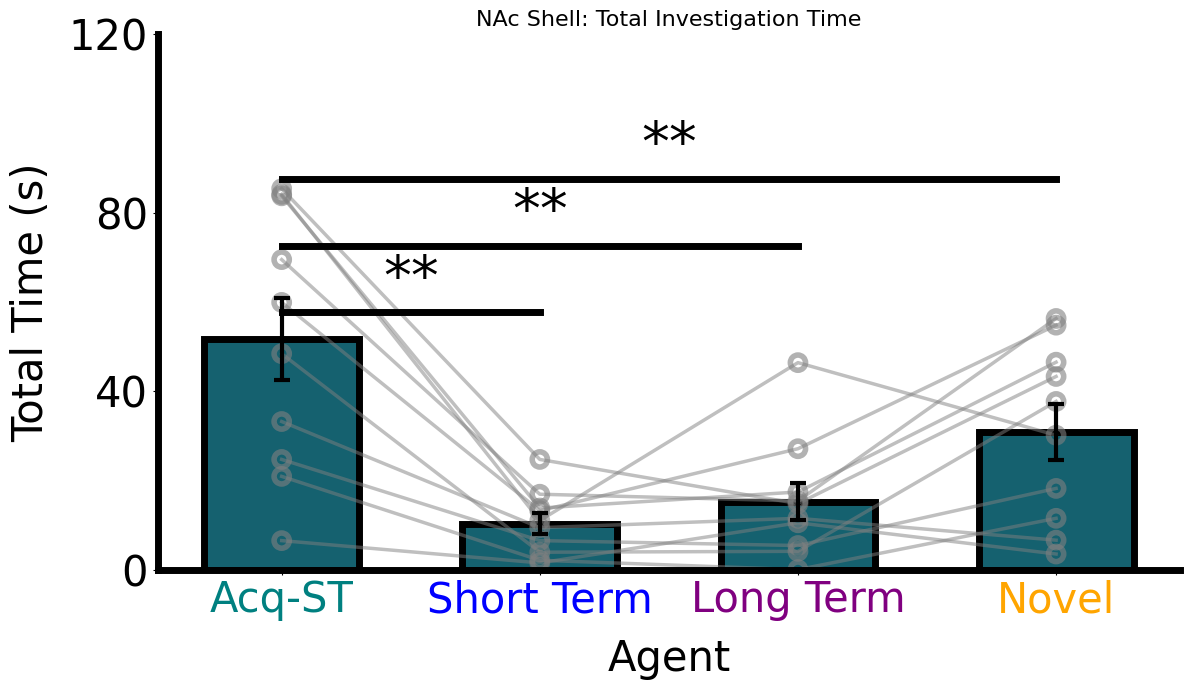

In [56]:
plot_y_across_bouts_gray(
    df=pivot_df,
    title="NAc Shell: Total Investigation Time",
    ylabel="Total Time (s)",
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(0,120),
    yticks_increment=40,
    bar_color=brain_region,
    xlabel="Agent",
    figsize=(12,7),
    pad_inches=0.1
)

### Average Bout Duration

In [59]:
desired_bouts = ["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"]

dfs = get_trial_dataframes(experiment)
ready_df = create_subject_summary_df(dfs)

pivot = process_investigation_data(
    ready_df,
    behavior_name="Investigation",   # or "Approach" if you prefer
    gap_threshold=0.3,
    min_duration=.00000000000000001,
    desired_bouts=desired_bouts,
    agg_func='mean'
)

In [60]:
# Define the desired order of the bars
desired_order = ["Acq-ST", "Short Term", "Long Term", "Novel"]

# Map original bout names to new labels
bout_rename_mapping = {
    "Short_Term-1": "Acq-ST",
    "Short_Term-2": "Short Term",
    "Long_Term-1": "Long Term",
    "Novel-1": "Novel"
}

# Rename columns in pivot_df
pivot_df = pivot.rename(columns=bout_rename_mapping)

# Reorder columns based on desired order
pivot_df = pivot_df[desired_order]

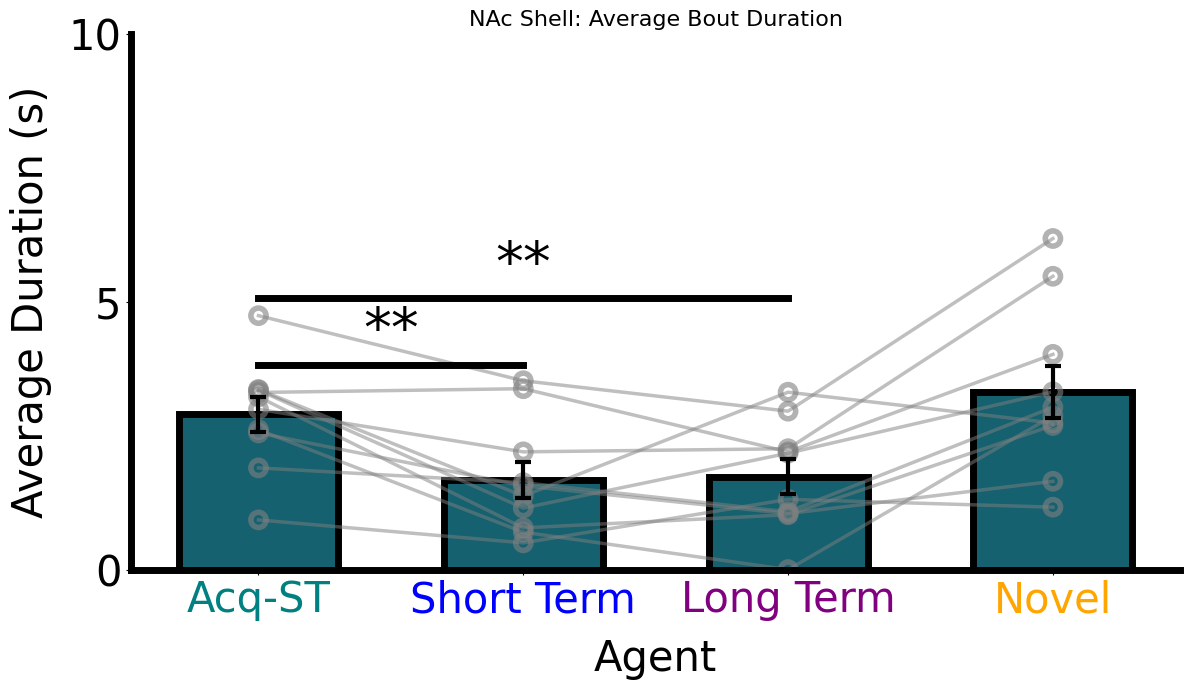

In [61]:
plot_y_across_bouts_gray(
    df=pivot_df,
    title="NAc Shell: Average Bout Duration",
    ylabel="Average Duration (s)",
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(0,10),
    yticks_increment=5,
    bar_color=brain_region,
    xlabel="Agent",
    figsize=(12,7),
    pad_inches=0.1
)

## Global DA

In [71]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)

# calculate event induced
experiment.compute_all_event_induced_DA(pre_time=4, post_time=5)

# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(
    use_fractional=True,       # Enable fractional analysis (limits window to max_bout_duration)
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    allow_bout_extension=True, # Allow extending the bout window if needed
    mode='standard'                 # Consider only the first investigation event per bout
)

Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for n4-240509-075317...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...
Processing behaviors for n7-240824-062103...
Computing event-induced DA for trial nn4-250121-084228 ...
Computing event-induced DA for trial nn7-250121-094048 ...
Computing event-induced DA for trial nn8-250121-101912 ...
Computing event-induced DA for trial nn6-250120-085156 ...
Computing event-induced DA for trial nn5-250120-081227 ...
Computing event-induced DA for trial nn1-250120-063024 ...
Computing event-induced DA for trial n4-240509-075317 ...
Computing event-induced DA for trial nn3-250121-074834 ...
Computing event-induced DA for trial nn2-250120-072910 ...
Computing ev

In [94]:
def plot_da_metrics_combined_oneplot_integrated(experiment, 
                                                metric_name="Mean Z-score", 
                                                title="Combined DA Metrics", 
                                                ylabel="DA Metric", 
                                                xlabel="Bout", 
                                                custom_xtick_labels=None, 
                                                custom_xtick_colors=None, 
                                                ylim=None, 
                                                bar_color="#00B7D7", 
                                                yticks_increment=None, 
                                                figsize=(14,8), 
                                                pad_inches=0.1):
    """
    Plots DA metrics across specific bouts for all trials in the experiment.
    If p-value < 0.05, it adds a horizontal significance line + asterisk above bars.

    Updates:
    - Unfilled circle markers for individual trials
    - Thick grey outlines for visibility
    """

    def perform_t_tests(pivot_df):
        """Performs paired t-tests comparing Acq-ST with Short Term, Long Term, and Novel."""
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }

        results = {}

        for key, (bout1, bout2) in comparisons.items():
            if bout1 in pivot_df.columns and bout2 in pivot_df.columns:
                paired_df = pivot_df[[bout1, bout2]].dropna()
                
                if len(paired_df) > 1:
                    t_stat, p_value = ttest_rel(paired_df[bout1], paired_df[bout2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        
        return results

    # Collect per-trial data for the chosen metric
    trial_data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, "behaviors") and not trial.behaviors.empty:
            trial_df = trial.behaviors.copy()
            if metric_name not in trial_df.columns:
                print(f"Warning: Trial '{trial_name}' does not contain metric '{metric_name}'. Skipping.")
                continue
            df_grouped = trial_df.groupby("Bout", as_index=False)[metric_name].mean()
            df_grouped["Trial"] = trial_name
            trial_data.append(df_grouped)
        else:
            print(f"Warning: Trial '{trial_name}' has no behavior data.")

    if not trial_data:
        print("No data available to plot.")
        return

    # Combine all trial data into a single DataFrame.
    combined_df = pd.concat(trial_data, ignore_index=True)

    # Select only 6 bouts
    selected_bouts = combined_df["Bout"].unique()[:6]
    combined_df = combined_df[combined_df["Bout"].isin(selected_bouts)]

    # Pivot the data for line plots: rows=Trial, columns=Bout, values=metric_name
    try:
        pivot_df = combined_df.pivot(index="Trial", columns="Bout", values=metric_name).fillna(0)
    except Exception as e:
        print("Error pivoting data for line plots:", e)
        return

    # Compute overall average and SEM for each Bout
    overall_stats = combined_df.groupby("Bout")[metric_name].agg(['mean', 'sem']).reset_index()

    # Now that pivot_df is created, perform t-tests
    t_test_results = perform_t_tests(pivot_df)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the overall average as a bar chart with error bars
    ax.bar(overall_stats["Bout"], overall_stats["mean"], yerr=overall_stats["sem"],
           capsize=6, color=bar_color, edgecolor='black', linewidth=5, width=0.6,
           error_kw=dict(elinewidth=3, capthick=3, zorder=5))
    
    # Overlay individual trial lines (all in gray)
    for trial in pivot_df.index:
        ax.plot(pivot_df.columns, pivot_df.loc[trial], linestyle='-', color='gray', 
                alpha=0.5, linewidth=3, marker='o', markerfacecolor='none', 
                markeredgecolor='gray', markeredgewidth=2, markersize=10)

    # Set labels and title
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=28)

    # Set exactly 6 x-tick labels
    xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"]
    xtick_colors=["teal", "blue", "purple", "orange"]

    ax.set_xticks(np.arange(4))
    ax.set_xticklabels(xtick_labels, fontsize=28)

    # Apply custom colors
    for tick, color in zip(ax.get_xticklabels(), xtick_colors):
        tick.set_color(color)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)
    
    # Set y-limits
    if ylim is None:
        all_values = np.concatenate([pivot_df.values.flatten(), overall_stats["mean"].values])
        ax.set_ylim(0, np.nanmax(all_values) * 1.2)
    else:
        ax.set_ylim(ylim)

    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)

    # Set y-ticks increment
    if yticks_increment is not None:
        y_min, y_max = ax.get_ylim()
        ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment))

    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # ---- Plot significance markers ---- #
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05  # Offset above bars

        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }

        line_spacing = sig_y_offset * 2.5  # Adjust spacing between lines
        current_y = np.nanmax(overall_stats["mean"]) + sig_y_offset  # Initial line position

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*" 

                    # Draw horizontal line
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)

                    # Add asterisks centered above the line
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance, 
                            fontsize=40, ha='center', color='black')

                    # Move the next line slightly higher to avoid overlap
                    current_y += line_spacing

    #plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout(pad=pad_inches)
    plt.show()


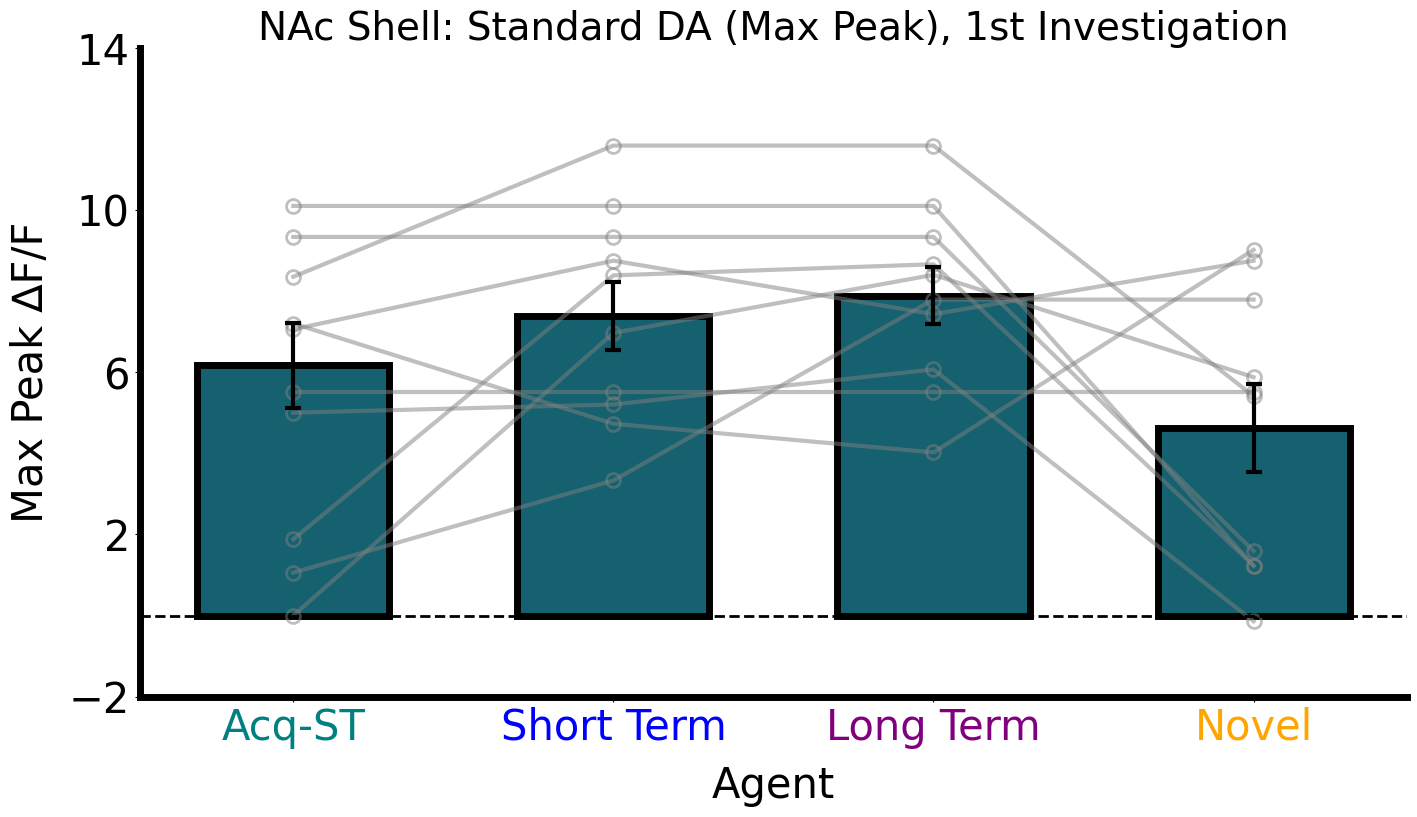

In [86]:
from scipy.stats import ttest_rel

plot_da_metrics_combined_oneplot_integrated(experiment,
                                                metric_name="Max Peak", 
                                                title="NAc Shell: Standard DA (Max Peak), 1st Investigation", 
                                                ylabel="Max Peak ∆F/F", 
                                                xlabel="Agent", 
                                                custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                                                custom_xtick_colors=["teal", "blue", "purple", "orange"], 
                                                ylim=(-2, 14), 
                                                bar_color=brain_region, 
                                                yticks_increment=4, 
                                                figsize=(14,8), 
                                                pad_inches=0.1)

# Mean Z-scored ∆F/F

## Event-Induced DA

In [93]:
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = True)

# calculate event induced
experiment.compute_all_event_induced_DA(pre_time=4, post_time=5)

experiment.compute_all_da_metrics(
    use_fractional=True,       # Enable fractional analysis (limits window to max_bout_duration)
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    allow_bout_extension=True, # Allow extending the bout window if needed
    mode='EI'                 # Consider only the first investigation event per bout
)

Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for n4-240509-075317...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...
Processing behaviors for n7-240824-062103...
Computing event-induced DA for trial nn4-250121-084228 ...
Computing event-induced DA for trial nn7-250121-094048 ...
Computing event-induced DA for trial nn8-250121-101912 ...
Computing event-induced DA for trial nn6-250120-085156 ...
Computing event-induced DA for trial nn5-250120-081227 ...
Computing event-induced DA for trial nn1-250120-063024 ...
Computing event-induced DA for trial n4-240509-075317 ...
Computing event-induced DA for trial nn3-250121-074834 ...
Computing event-induced DA for trial nn2-250120-072910 ...
Computing ev

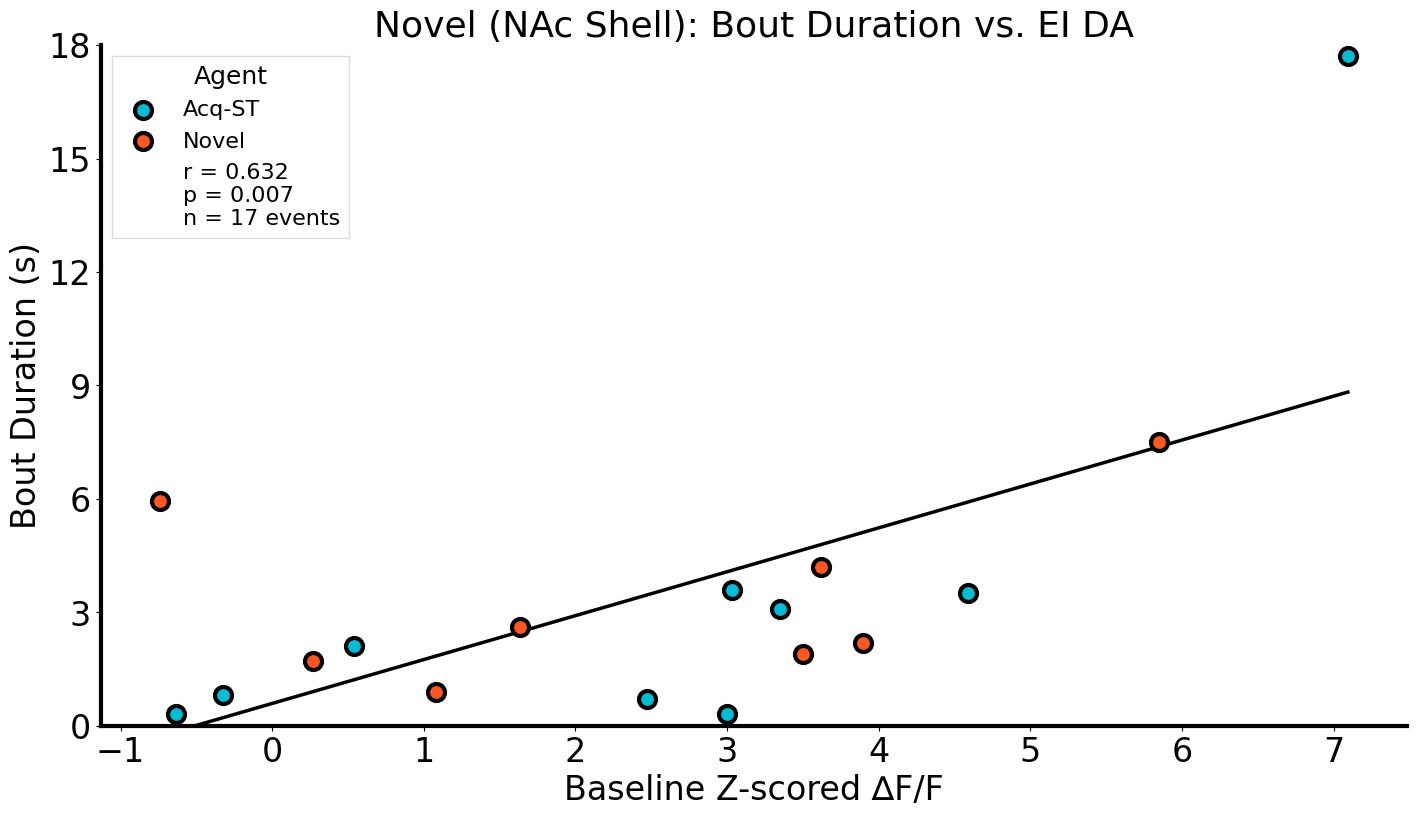

In [131]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy.stats import linregress
import pandas as pd

def plot_da_vs_duration_by_agent(experiment, 
                                 agents_of_interest, 
                                 agent_colors, 
                                 agent_labels, 
                                 title,
                                 da_metric='Mean Z-score',
                                 figsize=(10, 7),
                                 ylim=None,
                                 yticks_increment=None,
                                 xlabel = None,
                                 legend_loc='upper left',
                                 pad_inches=0.1):  # New parameter
    """
    Plot correlation between event-induced DA (Mean Z-score, AUC, or Max Peak) 
    and bout duration for selected agents.
    """
    valid_metrics = ['Mean Z-score', 'AUC', 'Max Peak']
    if da_metric not in valid_metrics:
        raise ValueError(f"Invalid da_metric. Choose from {valid_metrics}")

    trial_dfs = get_trial_dataframes(experiment)
    points = []

    for trial_id, df in zip(experiment.trials.keys(), trial_dfs):
        for bout_name in agents_of_interest:
            subset = df[(df["Bout"] == bout_name) & (df["Behavior"] == "Investigation")]
            if subset.empty:
                continue

            first_invest = subset.iloc[0]
            duration = first_invest["Duration (s)"]
            mean_z = first_invest.get("Mean Z-score", np.nan)
            auc = first_invest.get("AUC", np.nan)
            max_peak = first_invest.get("Max Peak", np.nan)

            prefix = bout_name.split('-')[0]
            agent_label = agent_labels.get(prefix, prefix)

            points.append({
                'Subject': trial_id,
                'Agent': agent_label,
                'Bout_Duration': duration,
                'Mean Z-score': mean_z,
                'AUC': auc,
                'Max Peak': max_peak
            })

    points_df = pd.DataFrame(points)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

    all_x, all_y = [], []

    for agent, group in points_df.groupby("Agent"):
        x = group[da_metric].values
        y = group["Bout_Duration"].values
        all_x.extend(x)
        all_y.extend(y)

        color = agent_colors.get(agent, 'gray')
        ax.scatter(x, y, color=color, s=150, alpha=1.0, edgecolor='black', linewidth=3, label=agent, zorder=3)

    # --- Regression Line (Pooled) ---
    stats_text_lines = ["r = ---", "p = ---", "n = ---"]
    if len(all_x) > 1:
        slope, intercept, r_val, p_val, _ = linregress(all_x, all_y)
        x_fit = np.linspace(min(all_x), max(all_x), 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, color='black', linewidth=2.5, linestyle='-', zorder=2)

        stats_text_lines = [
            f"r = {r_val:.3f}",
            f"p = {p_val:.3f}",
            f"n = {len(all_x)} events"
        ]

    # --- Labels ---
    ax.set_xlabel(xlabel, fontsize=24)
    ax.set_ylabel("Bout Duration (s)", fontsize=24)
    ax.set_title(title, fontsize=26)
    ax.tick_params(axis='both', labelsize=24)

    # X-axis label
    final_xlabel = xlabel if xlabel else da_metric
    ax.set_xlabel(final_xlabel, fontsize=24)


    # --- Y-axis formatting ---
    if ylim:
        ax.set_ylim(ylim)
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        yticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(yticks)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}' if x.is_integer() else f'{x}'))

    # --- Combined Legend ---
    handles, labels = ax.get_legend_handles_labels()
    stats_label = "\n".join(stats_text_lines)
    stats_handle = plt.Line2D([], [], color='none', label=stats_label)
    handles.append(stats_handle)
    labels.append(stats_label)

    legend = ax.legend(handles=handles, labels=labels, loc=legend_loc, fontsize=16, title='Agent', title_fontsize=18, 
                       frameon=True, facecolor='white', edgecolor='lightgray', fancybox=False)
    legend.get_frame().set_alpha(0.8)

    plt.tight_layout(pad=pad_inches)
    plt.savefig(f'{title}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.show()

    return points_df


#plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)

agents_of_interest = ['Short_Term-1', 'Novel-1']
agent_colors = {'Acq-ST': '#00BCD4', 'Novel': '#FF5722'}
agent_labels = {'Short_Term': 'Acq-ST', 'Novel': 'Novel'}

points_df = plot_da_vs_duration_by_agent(
    experiment=experiment,
    agents_of_interest=agents_of_interest,
    agent_colors=agent_colors,
    agent_labels=agent_labels,
    title="Novel (NAc Shell): Bout Duration vs. EI DA",
    da_metric='Mean Z-score',  # or 'Max Peak', or 'Mean Z-score'
    figsize=(14, 8),
    ylim=(0, 18),
    yticks_increment=3,
    xlabel = "Baseline Z-scored ∆F/F",
    legend_loc='upper left'
)
# Baseline Z-scored ∆F/F

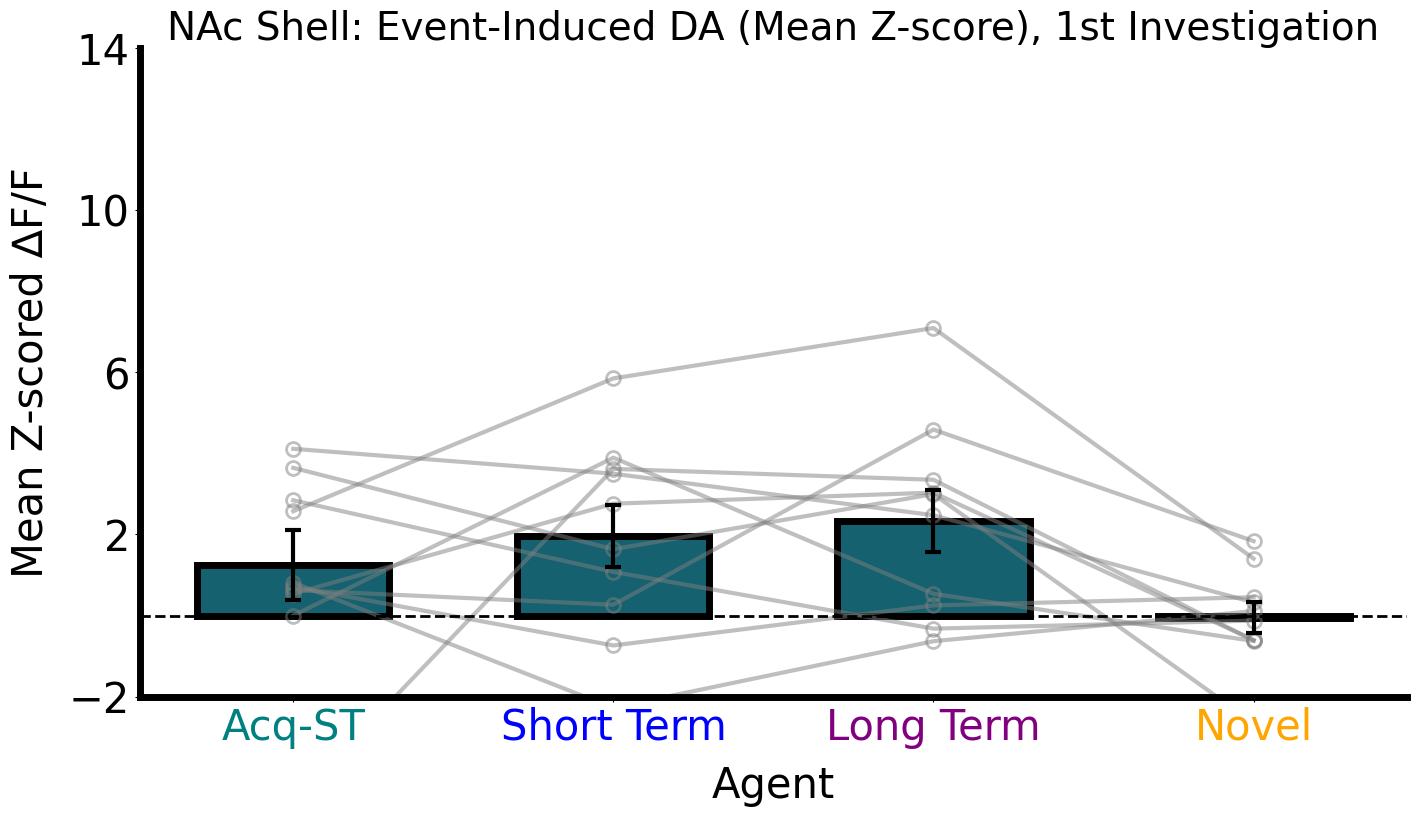

In [95]:
plot_da_metrics_combined_oneplot_integrated(experiment,
                                                metric_name="Mean Z-score", 
                                                title="NAc Shell: Event-Induced DA (Mean Z-score), 1st Investigation", 
                                                ylabel="Mean Z-scored ∆F/F", 
                                                xlabel="Agent", 
                                                custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                                                custom_xtick_colors=["teal", "blue", "purple", "orange"], 
                                                ylim=(-2, 14), 
                                                bar_color=brain_region, 
                                                yticks_increment=4, 
                                                figsize=(14,8), 
                                                pad_inches=0.1)

## 1st Investigation Stuff

In [21]:
def create_behavior_labeled_dataframe(experiment, behavior, n_start, n_end):
    """
    Collects all trial data from an experiment, then for each unique subject name
    and each of the 4 bout types, labels the first n_start to n_end occurrences
    of the specified behavior, without skipping partial sets.

    Parameters
    ----------
    experiment : object
        An object containing the 'trials' attribute, where each trial has a 'behaviors' DataFrame.
    behavior : str
        The behavior type to label (e.g., 'Investigation', 'Approach').
    n_start : int
        The starting index (1-based) for labeling occurrences.
    n_end : int
        The ending index (inclusive, 1-based) for labeling occurrences.

    Returns
    -------
    pd.DataFrame
        A DataFrame with a new 'behavior_label' column for the labeled occurrences.
    """

    # Define the bout types of interest
    bout_types = ["Long_Term-1", "Short_Term-1", "Short_Term-2", "Novel-1"]

    # 1) Gather all trial data into one list
    all_data = []
    for trial_id, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and isinstance(trial.behaviors, pd.DataFrame):
            df_trial = trial.behaviors.copy()
            df_trial['trial_id'] = trial_id
            df_trial['subject_name'] = trial.subject_name
            all_data.append(df_trial)

    # 2) Combine into a single DataFrame
    df_all = pd.concat(all_data, ignore_index=True)

    # 3) Filter to only rows where 'Behavior' matches the user-specified behavior (case-insensitive)
    df_all = df_all[df_all['Behavior'].str.lower() == behavior.lower()].copy()

    # 4) We'll store our final labeled rows here
    labeled_list = []

    # 5) Loop over each subject and each desired bout type
    for subject_name in df_all['subject_name'].unique():
        df_subject = df_all[df_all['subject_name'] == subject_name]

        for bout in bout_types:
            df_bout = df_subject[df_subject['Bout'] == bout].copy()

            # If you have a time column (e.g. 'Event_Start'), sort so you label in chronological order
            if 'Event_Start' in df_bout.columns:
                df_bout = df_bout.sort_values(by='Event_Start')

            # Now slice from n_start-1 to n_end (because DataFrame is 0-based, but user might say "1..5")
            # This will select the n_start-th occurrence up to the n_end-th occurrence
            df_bout = df_bout.iloc[n_start-1:n_end].copy()

            # If there's nothing to label, move on
            if df_bout.empty:
                continue

            # Create a 'behavior_label' that goes from 1.. up to however many rows we selected
            # (If you need 1..n_end exactly, that's fine; if fewer rows exist, they'll get 1..fewer)
            df_bout['behavior_label'] = range(1, len(df_bout) + 1)

            # Append these labeled rows to our master list
            labeled_list.append(df_bout)

    # 6) Combine all labeled chunks into the final DataFrame
    df_labeled = pd.concat(labeled_list, ignore_index=True) if labeled_list else pd.DataFrame()

    return df_labeled

experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = None)

experiment.compute_all_da_metrics(
    use_fractional=True,       # Enable fractional analysis (limits window to max_bout_duration)
    max_bout_duration=5,       # Set the maximum bout duration to 5 seconds
    use_adaptive=True,         # Enable adaptive peak-following window
    allow_bout_extension=True, # Allow extending the bout window if needed
    mode='standard'                 # Consider only the first investigation event per bout
)

Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for n4-240509-075317...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...
Processing behaviors for n7-240824-062103...
Computing DA metrics for nn4-250121-084228 ...
Computing DA metrics for nn7-250121-094048 ...
Computing DA metrics for nn8-250121-101912 ...
Computing DA metrics for nn6-250120-085156 ...
Computing DA metrics for nn5-250120-081227 ...
Computing DA metrics for nn1-250120-063024 ...
Computing DA metrics for n4-240509-075317 ...
Computing DA metrics for nn3-250121-074834 ...
Computing DA metrics for nn2-250120-072910 ...
Computing DA metrics for n7-240824-062103 ...


In [22]:
df_labeled = create_behavior_labeled_dataframe(
    experiment=experiment,
    behavior="Investigation",
    n_start=1,  # Currently unused in this version, but you can incorporate it if needed
    n_end=5
)

In [23]:
def compute_mean_by_bout_label(df_labeled, value_column="Mean Z-score"):
    """
    Groups the labeled DataFrame by Bout and behavior_label,
    then computes the mean of the specified value_column.

    Parameters
    ----------
    df_labeled : pd.DataFrame
        Output from create_behavior_labeled_dataframe (must include 'Bout' and 'behavior_label').
    value_column : str
        The name of the numeric column to average.

    Returns
    -------
    pd.DataFrame
        A DataFrame with columns ['Bout', 'behavior_label', value_column],
        where value_column is the groupwise mean.
    """
    # Group by Bout and behavior_label, compute mean
    df_mean = (
        df_labeled
        .groupby(['Bout', 'behavior_label'])[value_column]
        .mean()
        .reset_index(name=f"{value_column}_mean")
    )
    return df_mean


In [24]:
df_mean = compute_mean_by_bout_label(df_labeled, value_column="Mean Z-score")
df_mean

,Bout,behavior_label,Mean Z-score_mean
0,Long_Term-1,1,0.329124
1,Long_Term-1,2,0.139440
2,Long_Term-1,3,0.143675
3,Long_Term-1,4,-0.180054
4,Long_Term-1,5,-0.385237
5,Novel-1,1,0.780188
6,Novel-1,2,0.027857
7,Novel-1,3,-0.196460
8,Novel-1,4,-0.276986
9,Novel-1,5,-0.073466


In [25]:
from scipy.stats import linregress
def plot_mean_across_bouts_custom(
    df_mean,
    metric_col="Mean Z-score_mean",
    metric_type='slope',
    colors=None,
    custom_xtick_labels=None,
    custom_legend_labels=None,
    ylim=None,
    xlabel="Investigation Bout Number",
    ylabel="Global Z-scored ΔF/F",
    plot_title=None
):
    """
    Plots the average metric (e.g., Mean Z-score) vs. behavior label for each bout,
    styled similarly to the provided reference plot.

    Parameters:
    -----------
    df_mean : pd.DataFrame
        DataFrame with columns ['Bout', 'behavior_label', metric_col].
        Typically the output of a group-by operation (e.g., compute_mean_by_bout_label).
    metric_col : str
        The column in df_mean that contains the metric to plot (default: "Mean Z-score_mean").
    metric_type : str
        The metric to compute and display for each line (default: 'slope').
        Currently only supports 'slope'.
    colors : list
        A list of colors to use for different bouts. If None, matplotlib defaults are used.
    custom_xtick_labels : list
        Custom labels for the x-ticks, if provided. Otherwise, defaults to the numeric labels.
    custom_legend_labels : list
        Custom labels for the legend, if provided. Otherwise, defaults to the bout names.
    ylim : tuple
        A tuple specifying the y-axis limits (min, max).
    xlabel : str
        Label for the X-axis (default: "Investigation Bout Number").
    ylabel : str
        Label for the Y-axis (default: "Global Z-scored ΔF/F").
    plot_title : str or None
        Title for the plot. If None, no title is shown.

    Returns:
    --------
    None
        Displays the line plot and prints the computed metric (e.g., slope) for each line.
    """
    # Ensure required columns
    if not {"Bout", "behavior_label", metric_col}.issubset(df_mean.columns):
        raise ValueError(f"df_mean must contain 'Bout', 'behavior_label', and '{metric_col}' columns.")

    bouts = df_mean['Bout'].unique()

    # Default color cycle if none is provided
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Make axes lines thicker
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # Font sizes
    ax.tick_params(axis='both', which='major', labelsize=48)

    metrics_dict = {}

    for i, bout in enumerate(bouts):
        df_bout = df_mean[df_mean['Bout'] == bout].copy()
        # Sort by behavior_label so the lines connect in ascending order
        df_bout.sort_values(by='behavior_label', inplace=True)

        x_vals = df_bout['behavior_label'].values
        y_vals = df_bout[metric_col].values

        # Compute slope if requested
        if metric_type.lower() == 'slope':
            slope, intercept, r_val, p_val, std_err = linregress(x_vals, y_vals)
            metrics_dict[bout] = slope
        else:
            raise ValueError("Currently, only 'slope' is supported for metric_type.")

        # Legend label
        if custom_legend_labels and i < len(custom_legend_labels):
            legend_text = custom_legend_labels[i]
        else:
            legend_text = bout

        # Append slope to the legend label
        legend_text += f" (slope: {metrics_dict[bout]:.3f})"

        color = colors[i % len(colors)]
        # Plot with bigger line widths and markers
        ax.plot(
            x_vals, y_vals,
            marker='o', linestyle='-',
            color=color,
            linewidth=5, markersize=30,  # big lines, big markers
            label=legend_text
        )

    # X-axis label
    ax.set_xlabel(xlabel, fontsize=44, labelpad=12)
    # Y-axis label
    ax.set_ylabel(ylabel, fontsize=44, labelpad=12)

    # Optional y-limits
    if ylim is not None:
        ax.set_ylim(ylim)

    # Set x-ticks
    if custom_xtick_labels:
        ax.set_xticks(np.arange(1, len(custom_xtick_labels) + 1))
        ax.set_xticklabels(custom_xtick_labels, fontsize=16)
    else:
        # By default, just label them using the numeric values we found
        unique_x = sorted(df_mean['behavior_label'].unique())
        ax.set_xticks(unique_x)
        ax.set_xticklabels([str(x) for x in unique_x], fontsize=44)

    # Plot title
    if plot_title:
        ax.set_title(plot_title, fontsize=20)

    # Add legend
    ax.legend(fontsize=26)

    # Tight layout
    plt.tight_layout()

    plt.savefig("my_plot.png", transparent=True, dpi=300)

    # Show the plot
    plt.show()

    # Print the metric results
    print("\n=== Computed Metric ({}): ===".format(metric_type.upper()))
    for bout, val in metrics_dict.items():
        print(f"Bout: {bout}, {metric_type} = {val:.3f}")



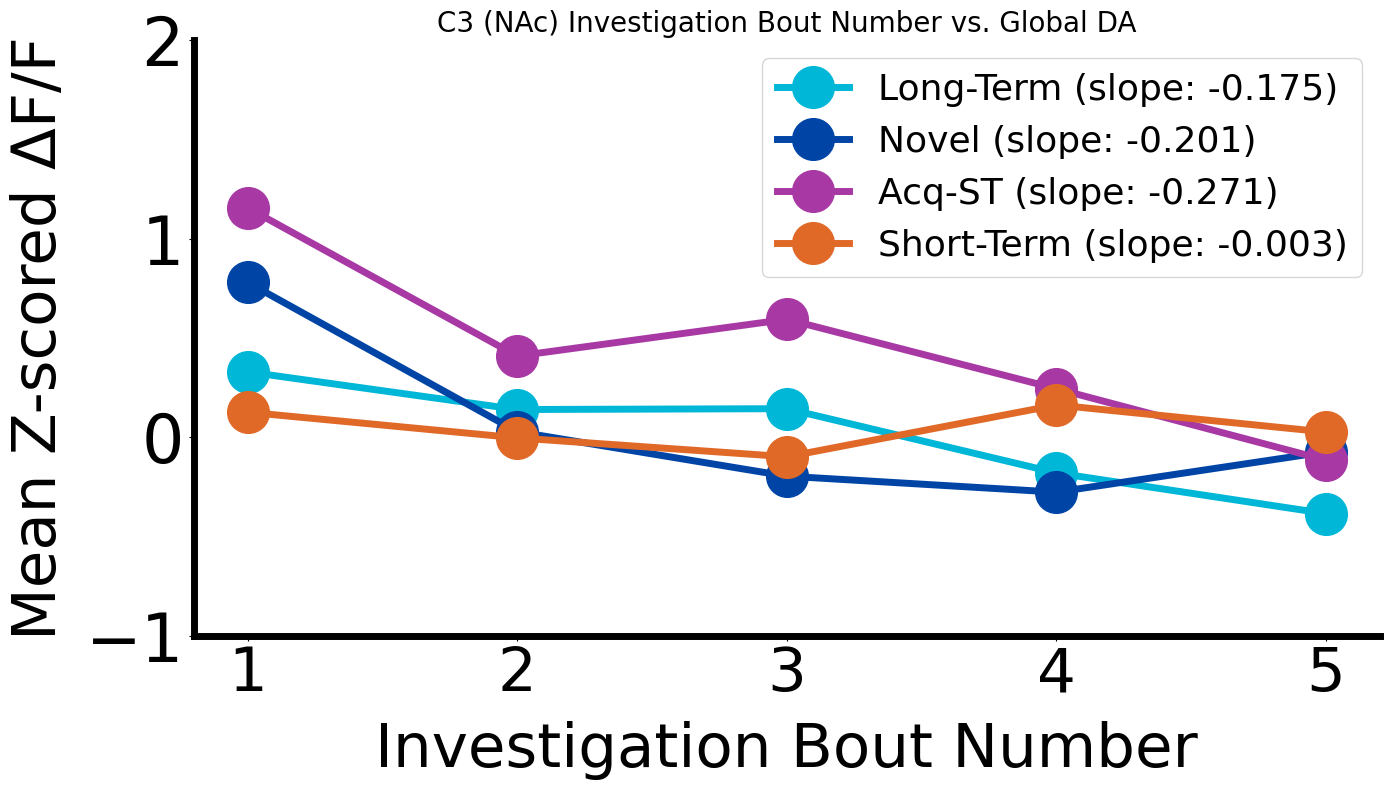


=== Computed Metric (SLOPE): ===
Bout: Long_Term-1, slope = -0.175
Bout: Novel-1, slope = -0.201
Bout: Short_Term-1, slope = -0.271
Bout: Short_Term-2, slope = -0.003


In [26]:
colors = ['#00B7D7','#0045A6','#A839A4','#E06928']

plot_mean_across_bouts_custom(
    df_mean=df_mean,
    metric_col="Mean Z-score_mean",
    metric_type='slope', 
    colors=colors,
    custom_xtick_labels=None,
    custom_legend_labels=['Long-Term', 'Novel', 'Acq-ST', 'Short-Term'],
    ylim=(-1, 2), 
    xlabel="Investigation Bout Number",
    ylabel="Mean Z-scored ΔF/F",
    plot_title="C3 (NAc) Investigation Bout Number vs. Global DA"
)

In [88]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_across_bouts_custom_v2(
    df_mean,
    metric_col="Mean Z-score_mean",
    metric_type='slope',
    line_order=None,
    custom_colors=None,
    custom_legend_labels=None,
    custom_xtick_labels=None,
    ylim=None,
    ytick_increment=None,  # <-- Changed from yticks_values to increment
    xlabel="Investigation Bout Number",
    ylabel="Global Z-scored ΔF/F",
    plot_title=None
):
    """
    Plots average metric (e.g., Mean Z-score) vs. behavior_label for each bout.
    Allows full customization of line order, colors, legend, and automatic y-ticks by increment.
    """

    if not {"Bout", "behavior_label", metric_col}.issubset(df_mean.columns):
        raise ValueError(f"df_mean must contain 'Bout', 'behavior_label', and '{metric_col}' columns.")

    bouts = line_order if line_order else df_mean['Bout'].unique()

    if custom_colors is None:
        custom_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='major', labelsize=48)

    metrics_dict = {}

    for i, bout in enumerate(bouts):
        df_bout = df_mean[df_mean['Bout'] == bout].copy()
        df_bout.sort_values(by='behavior_label', inplace=True)

        x_vals = df_bout['behavior_label'].values
        y_vals = df_bout[metric_col].values

        if len(x_vals) == 0 or len(y_vals) == 0:
            print(f"Skipping bout '{bout}' due to no data.")
            continue

        if metric_type.lower() == 'slope':
            slope, intercept, r_val, p_val, std_err = linregress(x_vals, y_vals)
            metrics_dict[bout] = slope
        else:
            raise ValueError("Currently, only 'slope' is supported.")

        legend_text = custom_legend_labels[i] if custom_legend_labels and i < len(custom_legend_labels) else bout
        legend_text += f" (slope: {metrics_dict[bout]:.3f})"

        color = custom_colors[i % len(custom_colors)]
        ax.plot(
            x_vals, y_vals,
            marker='o', linestyle='-',
            color=color,
            linewidth=5, markersize=30,
            label=legend_text
        )

    ax.set_xlabel(xlabel, fontsize=44, labelpad=12)
    ax.set_ylabel(ylabel, fontsize=44, labelpad=12)

    # --- Y-limits and Y-tick formatting ---
    if ylim is not None:
        ax.set_ylim(ylim)
        if ytick_increment is not None:
            y_ticks = np.arange(ylim[0], ylim[1] + ytick_increment, ytick_increment)
            ax.set_yticks(y_ticks)

            # Format tick labels: integer if whole number, else 1 decimal
            y_tick_labels = [f"{int(yt)}" if yt.is_integer() else f"{yt:.1f}" for yt in y_ticks]
            ax.set_yticklabels(y_tick_labels, fontsize=44)


    # --- X-ticks ---
    if custom_xtick_labels:
        ax.set_xticks(np.arange(1, len(custom_xtick_labels) + 1))
        ax.set_xticklabels(custom_xtick_labels, fontsize=44)
    else:
        unique_x = sorted(df_mean['behavior_label'].unique())
        ax.set_xticks(unique_x)
        ax.set_xticklabels([str(x) for x in unique_x], fontsize=44)

    if plot_title:
        ax.set_title(plot_title, fontsize=20)

    ax.legend(fontsize=26)
    plt.tight_layout()
    plt.savefig("my_plot.png", transparent=True, dpi=300)
    plt.show()

    print(f"\n=== Computed Metric ({metric_type.upper()}): ===")
    for bout, val in metrics_dict.items():
        print(f"Bout: {bout}, {metric_type} = {val:.3f}")


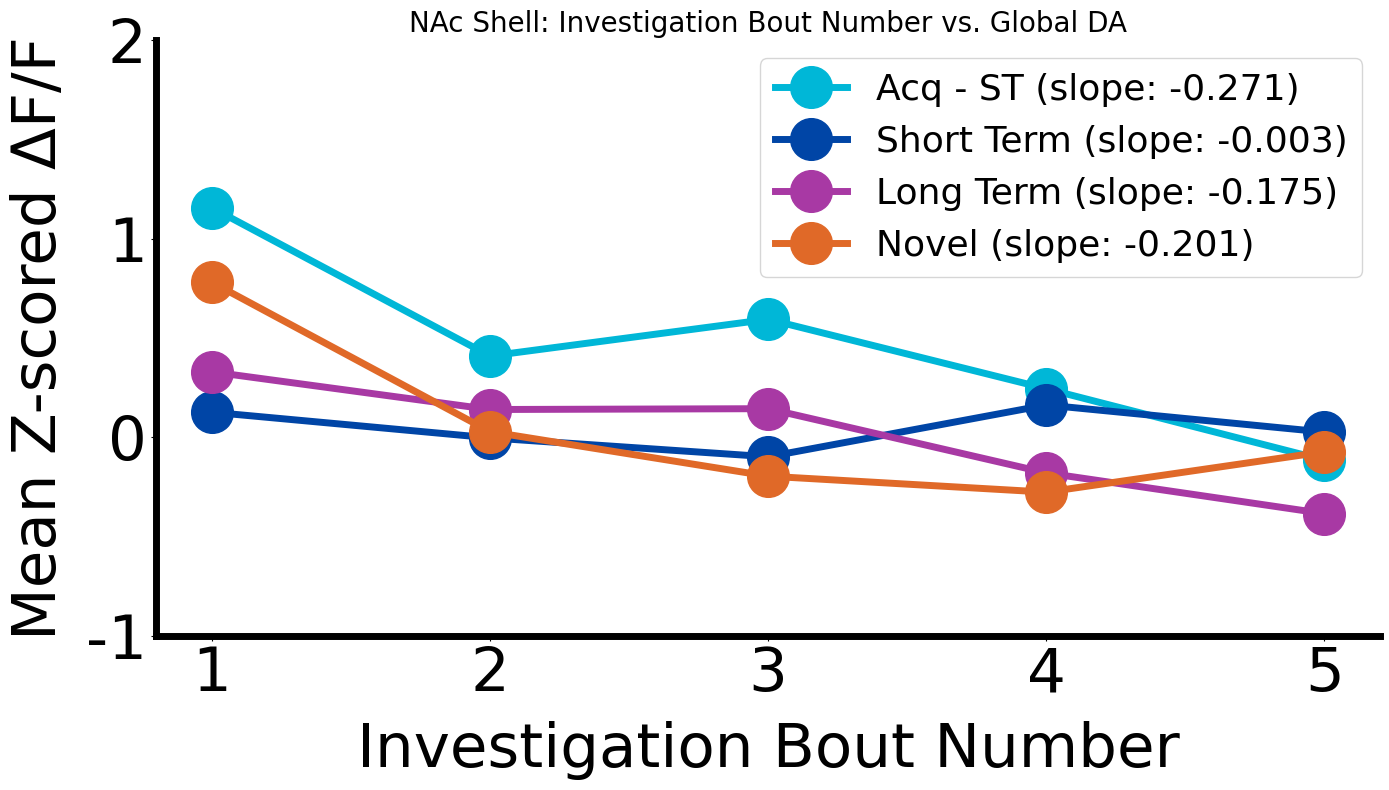


=== Computed Metric (SLOPE): ===
Bout: Short_Term-1, slope = -0.271
Bout: Short_Term-2, slope = -0.003
Bout: Long_Term-1, slope = -0.175
Bout: Novel-1, slope = -0.201


'\nplot_mean_across_bouts_custom_v2(\n    df_mean=df_mean,\n    metric_col="Mean Z-score_mean",\n    metric_type=\'slope\',\n    line_order=line_order,\n    custom_colors=custom_colors,\n    custom_legend_labels=custom_legend_labels,\n    custom_xtick_labels=[1, 2, 3, 4, 5],\n    ylim=(-1, 2),\n    ytick_increment=1,  # <-- Automatically sets -1, 0, 1, 2\n    xlabel="Investigation Bout Number",\n    ylabel="Mean Z-scored ΔF/F",\n    plot_title="C1-3 (mPFC) Investigation Bout Number vs. Global DA"\n)\n'

In [91]:
# Mapping: Real Bout Labels -> Legend Labels
label_mapping = {
    'Short_Term-1': 'Acq-ST',
    'Short_Term-2': 'Short Term',
    'Long_Term-1': 'Long Term',
    'Novel-1': 'Novel'
}

# Define plotting order of real bout labels
line_order = ['Short_Term-1', 'Short_Term-2', 'Long_Term-1', 'Novel-1']

# Matching colors for legend labels (poster order)
custom_colors = ['#00B7D7','#0045A6','#A839A4','#E06928']  # Teal, Dark Blue, Purple, Orange

# Matching legend labels (poster)
custom_legend_labels = ['Acq - ST', 'Short Term', 'Long Term', 'Novel']

# Call the plotting function with mapping support
plot_mean_across_bouts_custom_v2(
    df_mean=df_mean,
    metric_col="Mean Z-score_mean",
    metric_type='slope',
    line_order=line_order,
    custom_colors=custom_colors,
    custom_legend_labels=custom_legend_labels,
    custom_xtick_labels=[1, 2, 3, 4, 5],
    ylim=(-1, 2),
    ytick_increment=1,  # <-- Automatically sets -1, 0, 1, 2
    xlabel="Investigation Bout Number",
    ylabel="Mean Z-scored ΔF/F",
    plot_title="NAc Shell: Investigation Bout Number vs. Global DA"
)


'''
plot_mean_across_bouts_custom_v2(
    df_mean=df_mean,
    metric_col="Mean Z-score_mean",
    metric_type='slope',
    line_order=line_order,
    custom_colors=custom_colors,
    custom_legend_labels=custom_legend_labels,
    custom_xtick_labels=[1, 2, 3, 4, 5],
    ylim=(-1, 2),
    ytick_increment=1,  # <-- Automatically sets -1, 0, 1, 2
    xlabel="Investigation Bout Number",
    ylabel="Mean Z-scored ΔF/F",
    plot_title="C1-3 (mPFC) Investigation Bout Number vs. Global DA"
)
'''


## Ranks Stuff

In [29]:
import pandas as pd

def assign_subject_ranks_to_experiment(experiment, rank_csv_path):
    """
    Loads subject ranks from CSV and assigns each trial’s .behaviors DataFrame a new 'Rank' column.

    Parameters:
    - experiment : Experiment object
    - rank_csv_path : path to CSV with columns ['Subject', 'Rank']
    """
    # Load ranks
    rank_df = pd.read_csv(rank_csv_path)
    rank_dict = dict(zip(rank_df['Subject'].str.lower(), rank_df['Rank']))

    subjects_assigned = 0
    subjects_missing = []

    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            subject_prefix = trial_name[:3].lower()  # Match e.g., 'pp1', 'nn2'

            if subject_prefix in rank_dict:
                trial.behaviors["Rank"] = rank_dict[subject_prefix]
                subjects_assigned += 1
            else:
                trial.behaviors["Rank"] = None
                subjects_missing.append(trial_name)

    print(f"Ranks assigned to {subjects_assigned} trials.")
    if subjects_missing:
        print(f"No rank found for trials: {subjects_missing}")

In [30]:
rank_csv_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-3/Cohort_3_Ranks.csv"  # Update to your real CSV path
assign_subject_ranks_to_experiment(experiment, rank_csv_path)

Ranks assigned to 8 trials.
No rank found for trials: ['n4-240509-075317', 'n7-240824-062103']


In [31]:
def generate_investigation_per_agent_df(experiment, rank_csv_path=None, behavior_name='Investigation'):
    """
    Generates a DataFrame with Subject, Rank, and both Total Investigation Time
    and Average Bout Duration per Agent (Bout).

    Returns:
        DataFrame where rows = subjects, columns = [Total_Acq-ST, Avg_Acq-ST, ...], NaNs filled with 0.
    """
    import pandas as pd

    # Load rank CSV if provided
    rank_dict = {}
    if rank_csv_path:
        rank_df = pd.read_csv(rank_csv_path)
        if 'Subject' not in rank_df.columns or 'Rank' not in rank_df.columns:
            rank_df = pd.read_csv(rank_csv_path, header=None, names=['Subject', 'Rank'])
        rank_dict = dict(zip(rank_df['Subject'].str.lower(), rank_df['Rank']))

    data = []
    for trial_name, trial in experiment.trials.items():
        if hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()

            if behavior_name not in df['Behavior'].unique():
                continue

            df = df[df['Behavior'] == behavior_name].copy()
            if df.empty or 'Bout' not in df.columns:
                continue

            # Total duration per Agent
            total_per_agent = df.groupby('Bout')['Duration (s)'].sum()
            # Average bout duration per Agent
            avg_per_agent = df.groupby('Bout')['Duration (s)'].mean()

            # Subject ID
            subj_id = trial_name[:3].lower()
            rank = rank_dict.get(subj_id, None)

            row = {'Subject': subj_id, 'Rank': rank}
            for bout, total_val in total_per_agent.items():
                row[f'Total_{bout}'] = total_val
            for bout, avg_val in avg_per_agent.items():
                row[f'Avg_{bout}'] = avg_val

            data.append(row)

    # Final DataFrame with NaNs filled with 0
    agent_df = pd.DataFrame(data).set_index('Subject').fillna(0)
    return agent_df


In [32]:
agent_df = generate_investigation_per_agent_df(experiment, rank_csv_path=rank_csv_path)
agent_df

,Rank,Total_Long_Term-1,Total_Novel-1,Total_Short_Term-1,Total_Short_Term-2,Avg_Long_Term-1,Avg_Novel-1,Avg_Short_Term-1,Avg_Short_Term-2
Subject,,,,,,,,,
nn4,2.0,27.100,54.800,59.900,13.2,2.258333,5.480000,2.995000,2.200000
nn7,3.0,11.500,6.600,33.199,9.4,1.045455,1.650000,2.553769,1.566667
nn8,2.0,17.400,46.500,83.800,13.8,2.175000,3.321429,3.352000,1.150000
nn6,4.0,0.000,11.500,20.900,2.1,0.000000,2.875000,2.612500,0.700000
nn5,1.0,4.100,37.700,48.400,3.9,1.025000,2.692857,3.226667,0.780000
nn1,1.0,15.400,56.300,69.500,16.9,2.200000,4.021429,3.309524,3.380000
n4-,0.0,46.399,30.132,84.131,11.0,3.314214,2.739273,3.365240,1.375000
nn3,3.0,14.800,43.300,85.400,24.7,2.960000,6.185714,4.744444,3.528571
nn2,4.0,5.400,18.200,24.700,6.5,1.080000,3.033333,1.900000,1.625000


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D


def plot_y_across_bouts_gray(df,  
                             title='Mean Across Bouts', 
                             ylabel='Mean Value', 
                             custom_xtick_labels=None, 
                             custom_xtick_colors=None, 
                             ylim=None, 
                             bar_fill_color='white',     # NEW
                             bar_edge_color='black',     # NEW
                             bar_linewidth=3,            # NEW
                             bar_hatch='///',            # NEW
                             yticks_increment=None, 
                             xlabel='Agent',
                             figsize=(12,7), 
                             pad_inches=0.1,
                             rank_filter=None,
                             metric='Total'):
    """
    Plots mean Total Investigation Time or Average Bout Duration per Agent, with SEM and individual lines.

    Parameters:
        - df (DataFrame): Includes columns like 'Total_X' or 'Avg_X' per agent, plus 'Rank'.
        - metric (str): 'Total' or 'Avg' - determines which columns to plot.
        - rank_filter (int or None): Plot only subjects with this rank (if provided).
        - bar_fill_color (str): Fill color of the bars.
        - bar_edge_color (str): Edge color of the bars.
        - bar_linewidth (float): Width of the bar edges.
        - bar_hatch (str): Hatch pattern for the bars.
        [other params same as before]
    """

    # --- Filter by Rank ---
    if rank_filter is not None:
        if "Rank" not in df.columns:
            print("Rank filtering requested, but 'Rank' column not found.")
            return
        df = df[df["Rank"] == rank_filter]
        if df.empty:
            print(f"No data for Rank {rank_filter}.")
            return
        print(f"Plotting Rank {rank_filter} subjects: {len(df)} entries.")

    # --- Select columns by metric ---
    if metric not in ['Total', 'Avg']:
        raise ValueError("metric must be 'Total' or 'Avg'")
    value_columns = [col for col in df.columns if col.startswith(f"{metric}_")]

    if not value_columns:
        print(f"No columns found starting with '{metric}_'.")
        return

    df_plot = df[value_columns].copy()
    df_plot.columns = [col.replace(f"{metric}_", "") for col in df_plot.columns]

    # --- T-tests ---
    def perform_t_tests(df_vals):
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }
        results = {}
        for key, (b1, b2) in comparisons.items():
            if b1 in df_vals.columns and b2 in df_vals.columns:
                paired = df_vals[[b1, b2]].dropna()
                if len(paired) > 1:
                    t_stat, p_value = ttest_rel(paired[b1], paired[b2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        return results

    t_test_results = perform_t_tests(df_plot)

    # --- Stats ---
    mean_vals = df_plot.mean()
    sem_vals = df_plot.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # --- Bar Plot ---
    ax.bar(df_plot.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_fill_color, edgecolor=bar_edge_color, linewidth=bar_linewidth,
           width=0.6, hatch=bar_hatch,
           error_kw=dict(elinewidth=2, capthick=2, zorder=5))

     # --- Lines + Colored Markers ---
    for subject_id, row in df_plot.iterrows():
        subject_prefix = str(subject_id).lower().strip()
        if subject_prefix.startswith('n'):
            marker_color = '#15616F'  # NAc
        elif subject_prefix.startswith('p'):
            marker_color = '#FFAF00'  # mPFC
        else:
            marker_color = 'gray'  # fallback

        # Gray line
        ax.plot(df_plot.columns, row.values, linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

        # Colored opaque filled circles, no border, behind error bars
        ax.scatter(df_plot.columns, row.values, color=marker_color,
                   s=120, alpha=1.0, zorder=1)

    # --- Labels ---
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=16)

    # --- X-ticks ---
    ax.set_xticks(np.arange(len(df_plot.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(df_plot.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # --- Y-limits ---
    all_vals = np.concatenate([df_plot.values.flatten(), mean_vals.values])
    if ylim is None:
        min_val = np.nanmin(all_vals)
        max_val = np.nanmax(all_vals)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # --- Y-ticks ---
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # --- Aesthetic ---
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # --- Significance Markers ---
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }
        line_spacing = sig_y_offset * 2.5
        current_y = mean_vals.max() + sig_y_offset

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance,
                            fontsize=40, ha='center', color='black')
                    current_y += line_spacing
                    
    # --- Legend for Region Colors with Dots ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='NAc',
            markerfacecolor='#15616F', markersize=12, markeredgewidth=0),
        Line2D([0], [0], marker='o', color='none', label='mPFC',
            markerfacecolor='#FFAF00', markersize=12, markeredgewidth=0)
    ]

    ax.legend(handles=legend_elements, title="Region", fontsize=20, title_fontsize=22,
            loc='upper right', frameon=True)

    plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.tight_layout(pad=pad_inches)
    plt.show()


Plotting Rank 4 subjects: 2 entries.


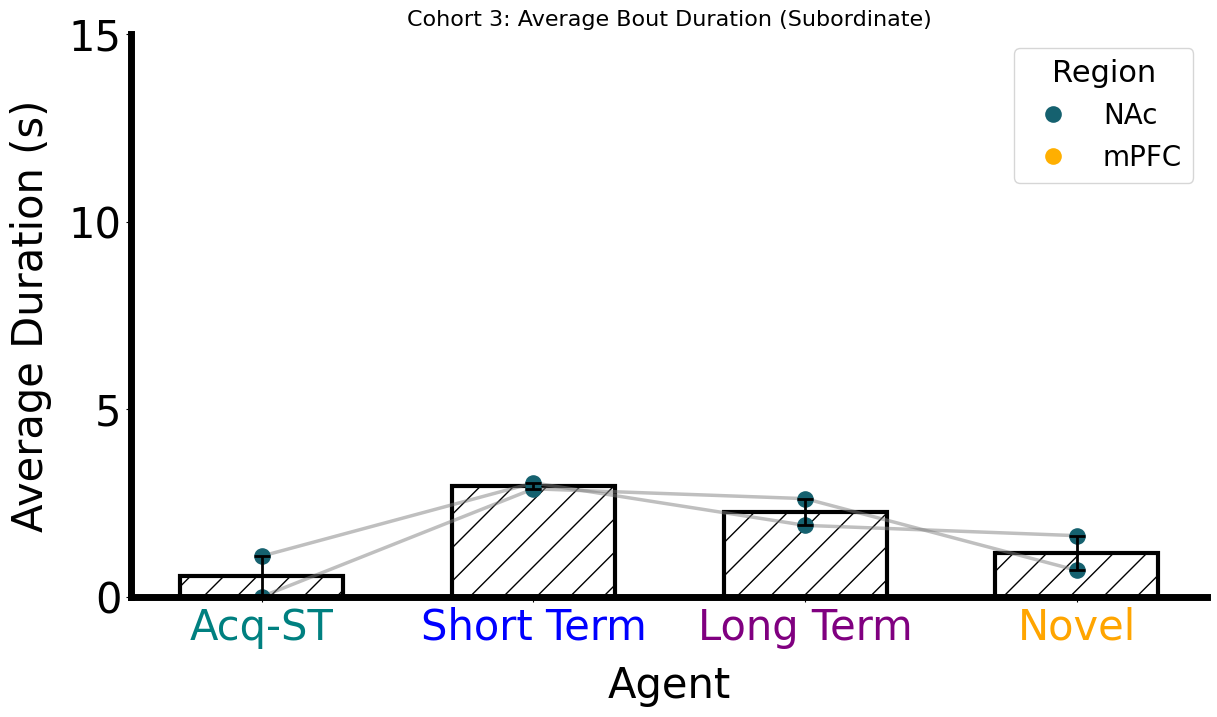

In [34]:
#plt.savefig(f'{title}{ylabel[0]}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)

plot_y_across_bouts_gray(
    df=agent_df,
    title="Cohort 3: Average Bout Duration (Subordinate)",
    ylabel="Average Duration (s)",
    metric='Avg',  # OR 'Avg'
    rank_filter=4,  # Optional: plot only rank 1 mice
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(0, 15),
    yticks_increment=5,
    bar_fill_color='white',     
    bar_edge_color='black',     
    bar_linewidth=3,            
    bar_hatch='/'         
)



In [35]:
import pandas as pd

def assign_ranks_and_combine_da_metrics(experiment, rank_csv_path):
    """
    Assigns subject ranks (from CSV) to each trial's behaviors DataFrame after DA metrics are computed.
    Then combines all trials into a single DataFrame with columns:
    ['Subject', 'Rank', 'Behavior', 'Bout', 'Event_Start', 'Event_End', 'Duration (s)',
     'AUC', 'Max Peak', 'Time of Max Peak', 'Mean Z-score', 'Original End', 'Adjusted End']
    
    Returns:
        combined_df (DataFrame): All behaviors + DA metrics + Rank, with Subject column.
    """

    # Load rank CSV
    rank_df = pd.read_csv(rank_csv_path)
    if 'Subject' not in rank_df.columns or 'Rank' not in rank_df.columns:
        rank_df.columns = ['Subject', 'Rank']  # fallback if no headers
    rank_dict = dict(zip(rank_df['Subject'].str.lower(), rank_df['Rank']))

    combined_rows = []
    assigned = 0

    for trial_name, trial in experiment.trials.items():
        subj_id = trial_name[:3].lower()  # e.g., pp1, nn2
        rank = rank_dict.get(subj_id, None)

        if rank is not None and hasattr(trial, 'behaviors') and not trial.behaviors.empty:
            df = trial.behaviors.copy()
            df['Subject'] = subj_id
            df['Rank'] = rank
            combined_rows.append(df)
            assigned += 1
        else:
            print(f"Skipped trial '{trial_name}' — no rank match or empty behaviors.")

    combined_df = pd.concat(combined_rows, ignore_index=True)
    print(f"Ranks assigned to {assigned} trials. Combined DataFrame shape: {combined_df.shape}")
    
    return combined_df



In [36]:
combined_df = assign_ranks_and_combine_da_metrics(experiment, rank_csv_path=rank_csv_path)
combined_df

Skipped trial 'n4-240509-075317' — no rank match or empty behaviors.
Skipped trial 'n7-240824-062103' — no rank match or empty behaviors.
Ranks assigned to 8 trials. Combined DataFrame shape: (344, 13)


,Bout,Behavior,Event_Start,Event_End,Duration (s),AUC,Max Peak,Time of Max Peak,Mean Z-score,Original End,Adjusted End,Rank,Subject
0,Long_Term-1,Approach,1189.8,1190.799,0.999,-5.176905,9.341657,1502.848912,-0.007822,1190.799,1851.640344,2,nn4
1,Long_Term-1,Approach,1200.0,1202.199,2.199,0.465607,9.341657,1502.848912,0.000713,1202.199,1851.640344,2,nn4
2,Long_Term-1,Investigation,1190.8,1193.100,2.300,-6.925459,9.341657,1502.848912,-0.010479,1193.100,1851.640344,2,nn4
3,Long_Term-1,Investigation,1202.2,1203.500,1.300,0.640098,1.167873,1202.741552,1.033481,1203.500,1202.820195,2,nn4
4,Long_Term-1,Investigation,1209.0,1209.400,0.400,-0.489903,9.341657,1502.848912,-0.000763,1209.400,1851.640344,2,nn4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,Short_Term-1,Investigation,759.5,764.400,4.900,2.309374,9.022015,1169.212024,0.002299,764.400,1764.063279,4,nn2
340,Short_Term-2,Investigation,855.1,855.900,0.800,-2.014023,9.022015,1169.212024,-0.002215,855.900,1764.063279,4,nn2
341,Short_Term-2,Investigation,1030.8,1033.300,2.500,-0.480334,-0.454687,1030.800978,-0.786750,1033.300,1031.411446,4,nn2
342,Short_Term-2,Investigation,1035.3,1037.100,1.800,3.720883,9.022015,1169.212024,0.005106,1037.100,1764.063279,4,nn2


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from matplotlib.lines import Line2D

def plot_da_metric_across_bouts(df,  
                                da_metric='Mean Z-score',  # New param
                                title='Mean DA Metric Across Bouts', 
                                ylabel='DA Value', 
                                custom_xtick_labels=None, 
                                custom_xtick_colors=None, 
                                ylim=None, 
                                bar_fill_color='white',     
                                bar_edge_color='black',     
                                bar_linewidth=3,            
                                bar_hatch='///',            
                                yticks_increment=None, 
                                xlabel='Agent',
                                figsize=(12,7), 
                                pad_inches=0.1,
                                rank_filter=None):
    """
    Plots the selected DA metric (e.g., AUC, Max Peak, Mean Z-score) per Agent with SEM bars and per-subject dots.

    Parameters:
        - df (DataFrame): Combined behaviors DataFrame including DA metrics and Rank.
        - da_metric (str): 'AUC', 'Max Peak', or 'Mean Z-score'.
        - rank_filter (int or None): If provided, plots only subjects of this rank.
        [Other params same as before]
    """

    # --- Filter Rank ---
    if rank_filter is not None:
        if "Rank" not in df.columns:
            print("Rank filtering requested, but 'Rank' column not found.")
            return
        df = df[df["Rank"] == rank_filter]
        if df.empty:
            print(f"No data for Rank {rank_filter}.")
            return
        print(f"Plotting Rank {rank_filter} subjects: {len(df['Subject'].unique())} unique subjects.")

    # --- Validate Metric ---
    valid_metrics = ['AUC', 'Max Peak', 'Mean Z-score']
    if da_metric not in valid_metrics:
        print(f"Invalid DA metric '{da_metric}'. Must be one of {valid_metrics}")
        return

    # --- Pivot Data: Subjects × Bouts (columns: Bouts, values: selected metric) ---
    pivot_df = (
        df.pivot_table(index='Subject', columns='Bout', values=da_metric, aggfunc='mean')
          .fillna(0)
    )

    if pivot_df.empty:
        print("Pivoted DataFrame is empty. Check input data.")
        return

    # --- T-tests ---
    def perform_t_tests(df_vals):
        comparisons = {
            "acq_st_vs_short_term": ("Acq-ST", "Short Term"),
            "acq_st_vs_long_term": ("Acq-ST", "Long Term"),
            "acq_st_vs_novel": ("Acq-ST", "Novel")
        }
        results = {}
        for key, (b1, b2) in comparisons.items():
            if b1 in df_vals.columns and b2 in df_vals.columns:
                paired = df_vals[[b1, b2]].dropna()
                if len(paired) > 1:
                    t_stat, p_value = ttest_rel(paired[b1], paired[b2])
                    results[key] = {"t_stat": t_stat, "p_value": p_value}
        return results

    t_test_results = perform_t_tests(pivot_df)

    # --- Stats ---
    mean_vals = pivot_df.mean()
    sem_vals = pivot_df.sem()

    fig, ax = plt.subplots(figsize=figsize)

    # --- Bar Plot ---
    ax.bar(pivot_df.columns, mean_vals, yerr=sem_vals, capsize=6,
           color=bar_fill_color, edgecolor=bar_edge_color, linewidth=bar_linewidth,
           width=0.6, hatch=bar_hatch,
           error_kw=dict(elinewidth=2, capthick=2, zorder=5))

    # --- Lines + Colored Dots ---
    for subj_id, row in pivot_df.iterrows():
        prefix = str(subj_id).lower().strip()
        if prefix.startswith('n'):
            dot_color = '#15616F'  # NAc
        elif prefix.startswith('p'):
            dot_color = '#FFAF00'  # mPFC
        else:
            dot_color = 'gray'

        # Gray line
        ax.plot(pivot_df.columns, row.values, linestyle='-', color='gray',
                alpha=0.5, linewidth=2.5, zorder=1)

        # Colored opaque dots (no border, behind error bars)
        ax.scatter(pivot_df.columns, row.values, color=dot_color,
                   s=120, alpha=1.0, zorder=1)

    # --- Labels ---
    ax.set_ylabel(ylabel, fontsize=30, labelpad=12)
    ax.set_xlabel(xlabel, fontsize=30, labelpad=12)
    ax.set_title(title, fontsize=18)

    # --- X-ticks ---
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    if custom_xtick_labels:
        ax.set_xticklabels(custom_xtick_labels, fontsize=28)
        if custom_xtick_colors:
            for tick, color in zip(ax.get_xticklabels(), custom_xtick_colors):
                tick.set_color(color)
    else:
        ax.set_xticklabels(pivot_df.columns, fontsize=26)

    ax.tick_params(axis='y', labelsize=30)
    ax.tick_params(axis='x', labelsize=30)

    # --- Y-limits ---
    all_vals = np.concatenate([pivot_df.values.flatten(), mean_vals.values])
    if ylim is None:
        min_val = np.nanmin(all_vals)
        max_val = np.nanmax(all_vals)
        lower_ylim = 0 if min_val > 0 else min_val * 1.1
        upper_ylim = max_val * 1.1
        ax.set_ylim(lower_ylim, upper_ylim)
        if lower_ylim < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)
    else:
        ax.set_ylim(ylim)
        if ylim[0] < 0:
            ax.axhline(0, color='black', linestyle='--', linewidth=2, zorder=1)

    # --- Y-ticks ---
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(y_ticks)

    # --- Aesthetic ---
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)

    # --- Significance Markers ---
    if t_test_results:
        max_y = ax.get_ylim()[1]
        sig_y_offset = max_y * 0.05
        comparisons = {
            "acq_st_vs_short_term": (0, 1),
            "acq_st_vs_long_term": (0, 2),
            "acq_st_vs_novel": (0, 3)
        }
        line_spacing = sig_y_offset * 2.5
        current_y = mean_vals.max() + sig_y_offset

        for key, (x1, x2) in comparisons.items():
            if key in t_test_results:
                p_value = t_test_results[key]["p_value"]
                if p_value < 0.05:
                    significance = "**" if p_value < 0.01 else "*"
                    ax.plot([x1, x2], [current_y, current_y], color='black', linewidth=5)
                    ax.text((x1 + x2) / 2, current_y + sig_y_offset / 1.5, significance,
                            fontsize=40, ha='center', color='black')
                    current_y += line_spacing

    '''
    # --- Legend for Dots ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='none', label='NAc',
               markerfacecolor='#15616F', markersize=12, markeredgewidth=0),
        Line2D([0], [0], marker='o', color='none', label='mPFC',
               markerfacecolor='#FFAF00', markersize=12, markeredgewidth=0)
    ]
    ax.legend(handles=legend_elements, title="Region", fontsize=20, title_fontsize=22,
              loc='upper right', frameon=True)
    '''
    # Save and show
    plt.tight_layout(pad=pad_inches)
    #plt.savefig(f'{title}_{da_metric}.png', transparent=True, bbox_inches='tight', pad_inches=pad_inches)
    plt.show()


Plotting Rank 4 subjects: 2 unique subjects.


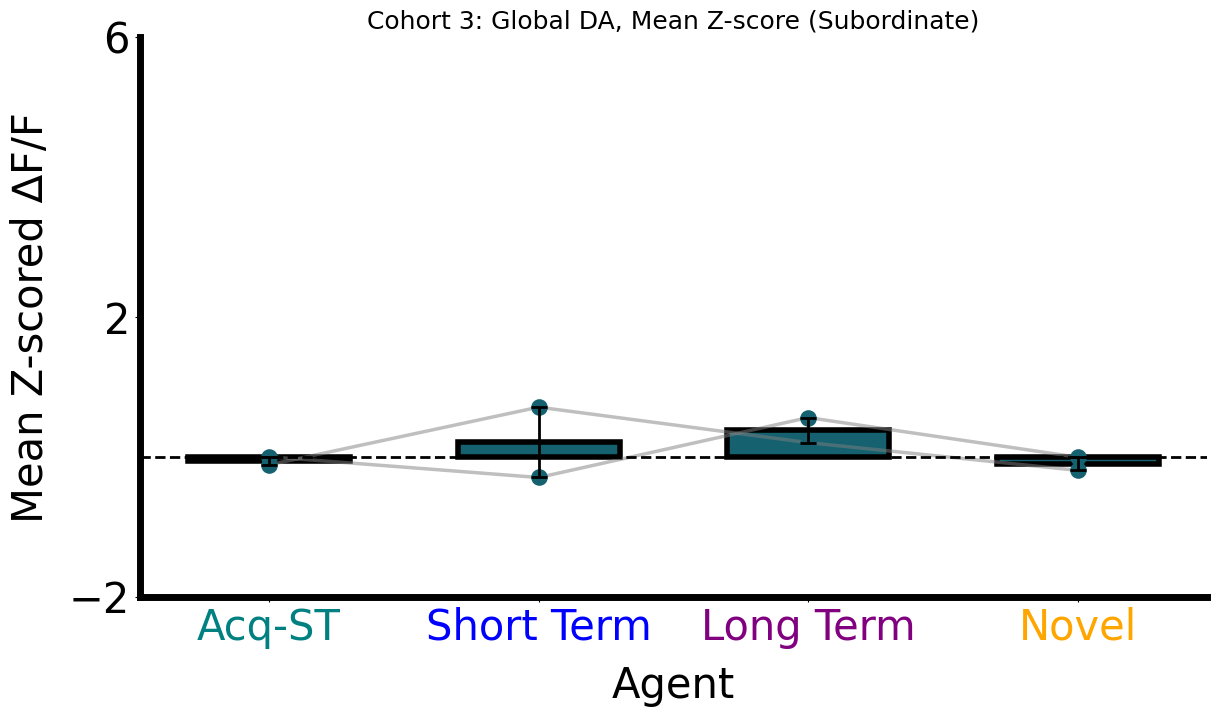

In [38]:
plot_da_metric_across_bouts(combined_df,
                            da_metric='Mean Z-score',
                            title='Cohort 3: Global DA, Mean Z-score (Subordinate)',
                            ylabel='Mean Z-scored ∆F/F',
                            bar_fill_color=brain_region,
                            bar_edge_color="Black",
                            bar_linewidth=4,
                            bar_hatch=None,
                            rank_filter=4,  # Plot only Rank 1 mice
                            custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
                            custom_xtick_colors=["teal", "blue", "purple", "orange"],
                            ylim=(-2, 6),
                            yticks_increment=4)

#Mean Z-scored ∆F/F